# Loading Libraries

In [1]:
# For Extracting only the alphabetic data
import re

# For reading the csv filees
import pandas as pd 

# for array manulupation
import numpy as np

# For preprocessing the Named labels into numeric form
from sklearn.preprocessing import LabelEncoder

# Vectorizing the Data into  numeric format
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Uncomment below cell to download these packages
# nltk.download('stopwords')

# For the Machine Learning Model Implementation
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# For cross validation application
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from yellowbrick.model_selection import CVScores

# For the training and testing splition
from sklearn.model_selection import train_test_split

# For the plotting of the metrics
import seaborn as sns
import matplotlib.pyplot as plt

# For the model Evaluations
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, plot_confusion_matrix, precision_score

# Loading the dataset

In [2]:
df = open("SMSSpamCollection.txt", 'r')
lines = df.readlines()

In [3]:
X = []
y = []
for line in lines:
    y.append(line.split("\t")[0])
    X.append(line.split("\t")[1])

In [4]:
df = pd.DataFrame()
df["text"] = X
df["labels"] = y

In [5]:
df.head()

,text,labels
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...\n,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


# Getting Classes counts

In [6]:
df['labels'].value_counts()

ham     4827
spam     747
Name: labels, dtype: int64

Text(0.5, 0, 'Message Length')

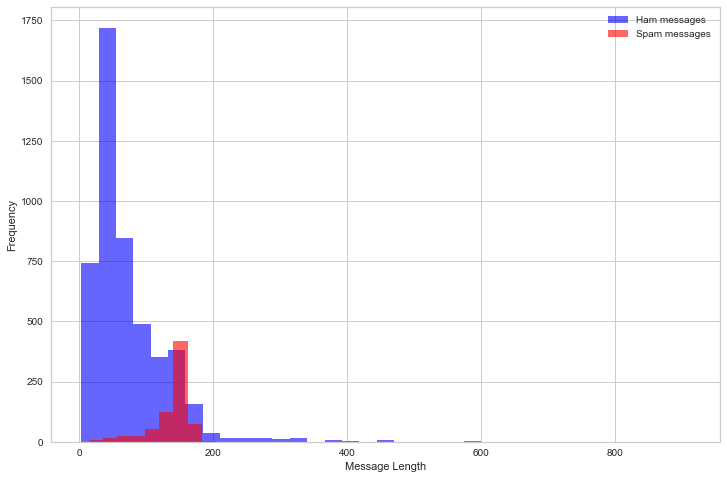

In [7]:
plt.figure(figsize=(12, 8))
df['message_len'] = df.text.apply(len)
df[df.labels=='ham'].message_len.plot(bins=35, kind='hist', color='blue', label='Ham messages', alpha=0.6)
df[df.labels=='spam'].message_len.plot(kind='hist', color='red', label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

# Applying preprocessing

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
lemma = WordNetLemmatizer()
def clean_text(text):
    totalStopwords = set([word.replace("'",'') for word in stopwords.words('english')])
    text = text.lower()
    text = text.replace("'",'')
    text = re.sub('[^a-zA-Z]',' ',text)
    words = text.split()
    words = [lemma.lemmatize(word) for word in words if (word not in totalStopwords) and (len(word)>1)] # Remove stop words
    text = " ".join(words)
    return text

In [10]:
X_train = list(map(clean_text, X_train))
X_test  = list(map(clean_text, X_test))

In [11]:
X_train[:10]

['gorgeous keep pix cumming thank',
 'cash prize claim call rstm sw s ppm',
 'sent like',
 'quite late lar ard anyway wun drivin',
 'beautiful tomorrow never come come already today hunt beautiful tomorrow waste wonderful today goodmorning',
 'coming friday leave pongal get news work place',
 'hi dear call urgnt know whats problem want work problem least tell wating reply',
 'phone weirdest auto correct',
 'telly brdget jones',
 'lol great im getting hungry']

In [12]:
le = LabelEncoder()
y_train = list(le.fit_transform(y_train))
y_test  = list(le.transform(y_test))

In [13]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Saving features arff file

In [14]:
with open("formated.arff", "w") as f:
    for line in vectorizer.transform(X).toarray():
        f.write(str([i for i in line]).replace("[", "").replace("]", "") + "\n")

# **Applying 5 Machine Learning Algorithms**

In [15]:
def make_cross_validation(model, X, y):
    # prepare the cross-validation procedure
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    visualizer = CVScores(model, cv=cv, scoring='accuracy')
    # Fit the data to the visualizer
    visualizer.fit(X, y)    
    # Display the visualizer
    visualizer.show()
    # Return the scores of the cross validation
    return scores

In [20]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix

# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='viridis')
    plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro')]
    return results

# Decision tree Classifier

========== Decision tree Classifier ==========

Accuracy on validation set: 0.9617

Classification report : 
               precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1447
        spam       0.86      0.85      0.86       226

    accuracy                           0.96      1673
   macro avg       0.92      0.92      0.92      1673
weighted avg       0.96      0.96      0.96      1673


Confusion Matrix : 
 [[1416   31]
 [  33  193]]


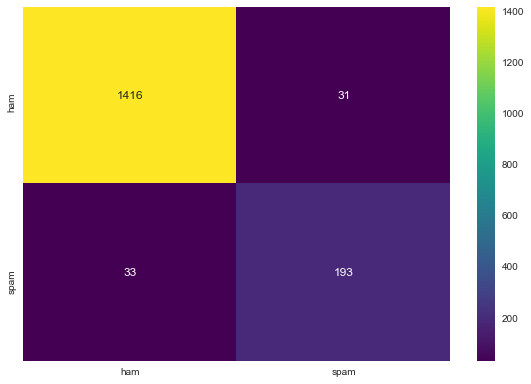

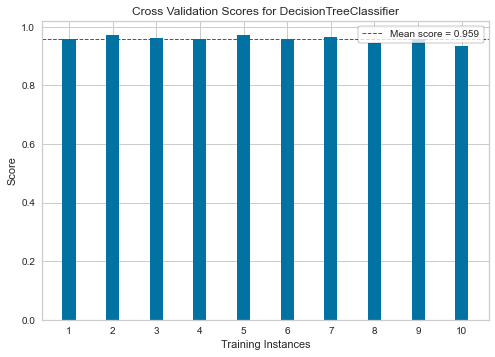

In [21]:
# Decision tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
results_dt = modelEvaluation(y_pred, y_test, "Decision tree Classifier", le.classes_)
dtc_accuracy = np.average(make_cross_validation(dtc, X_train, y_train))

# Multinomial Naive Bayes Classifier

========== Multinomial Naive Bayes Classifier ==========

Accuracy on validation set: 0.9689

Classification report : 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1447
        spam       0.99      0.77      0.87       226

    accuracy                           0.97      1673
   macro avg       0.98      0.89      0.93      1673
weighted avg       0.97      0.97      0.97      1673


Confusion Matrix : 
 [[1446    1]
 [  51  175]]


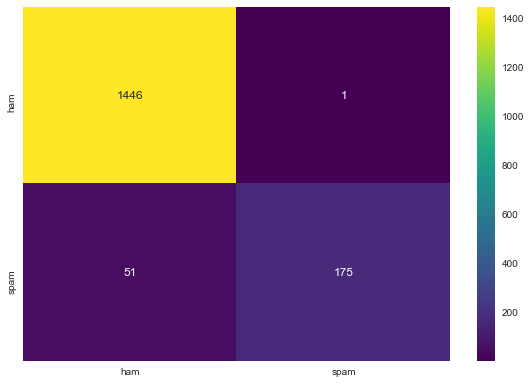

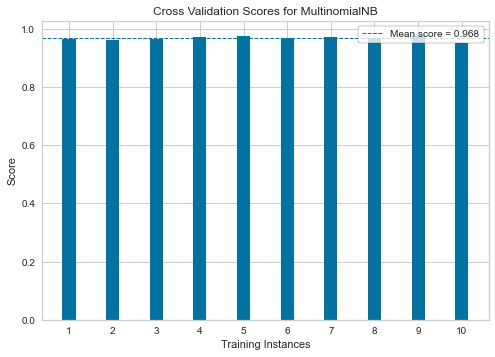

In [22]:
nbc = MultinomialNB()
nbc.fit(X_train, y_train)
y_pred = nbc.predict(X_test)
results_nb = modelEvaluation(y_pred, y_test, "Multinomial Naive Bayes Classifier", le.classes_)
nbc_accuracy = np.average(make_cross_validation(nbc, X_train, y_train))

# K-Nearest Neighbour Classifier

========== K-Nearest Neighbour Classifier ==========

Accuracy on validation set: 0.9121

Classification report : 
               precision    recall  f1-score   support

         ham       0.91      1.00      0.95      1447
        spam       1.00      0.35      0.52       226

    accuracy                           0.91      1673
   macro avg       0.95      0.67      0.73      1673
weighted avg       0.92      0.91      0.89      1673


Confusion Matrix : 
 [[1447    0]
 [ 147   79]]


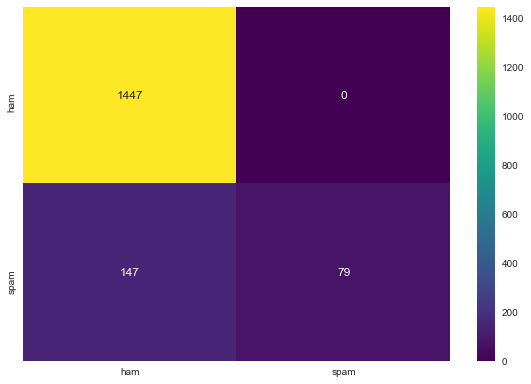

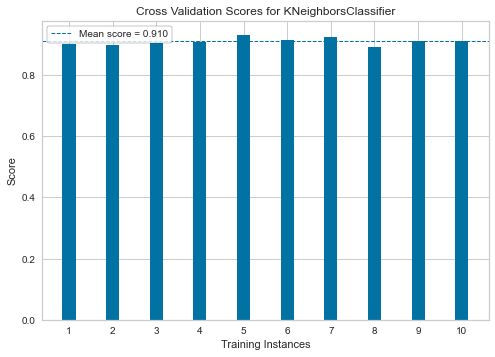

In [23]:
knnc = KNeighborsClassifier()
knnc.fit(X_train, y_train)
y_pred = knnc.predict(X_test)
results_knn = modelEvaluation(y_pred, y_test, "K-Nearest Neighbour Classifier", le.classes_)
knnc_accuracy = np.average(make_cross_validation(knnc, X_train, y_train))

# SVM Classifier

========== SVC Classifier ==========

Accuracy on validation set: 0.9827

Classification report : 
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1447
        spam       0.99      0.88      0.93       226

    accuracy                           0.98      1673
   macro avg       0.99      0.94      0.96      1673
weighted avg       0.98      0.98      0.98      1673


Confusion Matrix : 
 [[1445    2]
 [  27  199]]


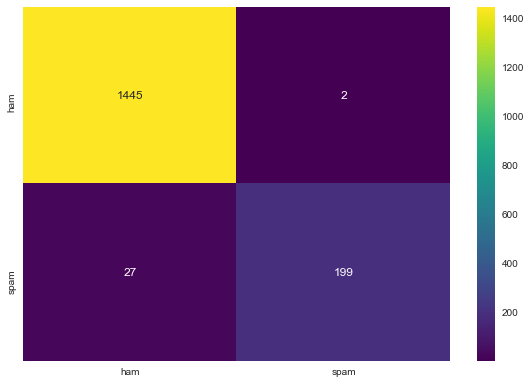

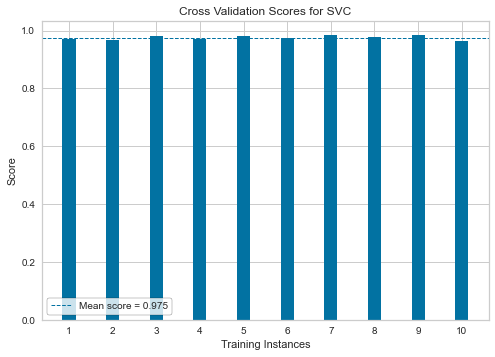

In [24]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
results_svc = modelEvaluation(y_pred, y_test, "SVC Classifier", le.classes_)
svc_accuracy = np.average(make_cross_validation(svc, X_train, y_train))

# Random Forest Classifier

========== Random Forest Classifier ==========

Accuracy on validation set: 0.9761

Classification report : 
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1447
        spam       0.99      0.83      0.90       226

    accuracy                           0.98      1673
   macro avg       0.98      0.92      0.95      1673
weighted avg       0.98      0.98      0.98      1673


Confusion Matrix : 
 [[1445    2]
 [  38  188]]


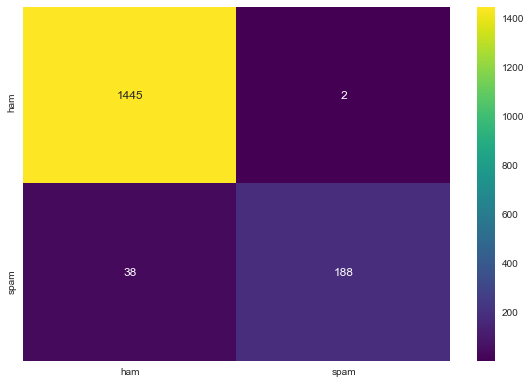

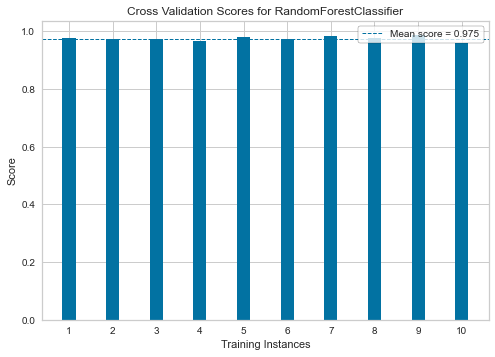

In [25]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
results_rf = modelEvaluation(y_pred, y_test, "Random Forest Classifier", le.classes_)
rfc_accuracy = np.average(make_cross_validation(rfc, X_train, y_train))

In [29]:
from tabulate import tabulate
# showing all models result
dic = {
    'Metrics':['accuracy','precision','recall','f1-score'],
    'Decision tree' : results_dt,
    'Naive Bayes' : results_nb,
    'KNN' : results_knn,
    'SVC' : results_svc,
    'Random Forest':results_rf
}
metrics_df = pd.DataFrame(dic)

metrics_df = metrics_df.set_index('Metrics')
# displaying the DataFrame
print(tabulate(metrics_df, headers = 'keys', tablefmt = 'psql'))

+-----------+-----------------+---------------+----------+----------+-----------------+
| Metrics   |   Decision tree |   Naive Bayes |      KNN |      SVC |   Random Forest |
|-----------+-----------------+---------------+----------+----------+-----------------|
| accuracy  |        0.961745 |      0.968918 | 0.912134 | 0.982666 |        0.976091 |
| precision |        0.919416 |      0.980125 | 0.95389  | 0.985854 |        0.981925 |
| recall    |        0.916279 |      0.886823 | 0.674779 | 0.939574 |        0.915238 |
| f1-score  |        0.917839 |      0.926492 | 0.734847 | 0.961075 |        0.945097 |
+-----------+-----------------+---------------+----------+----------+-----------------+


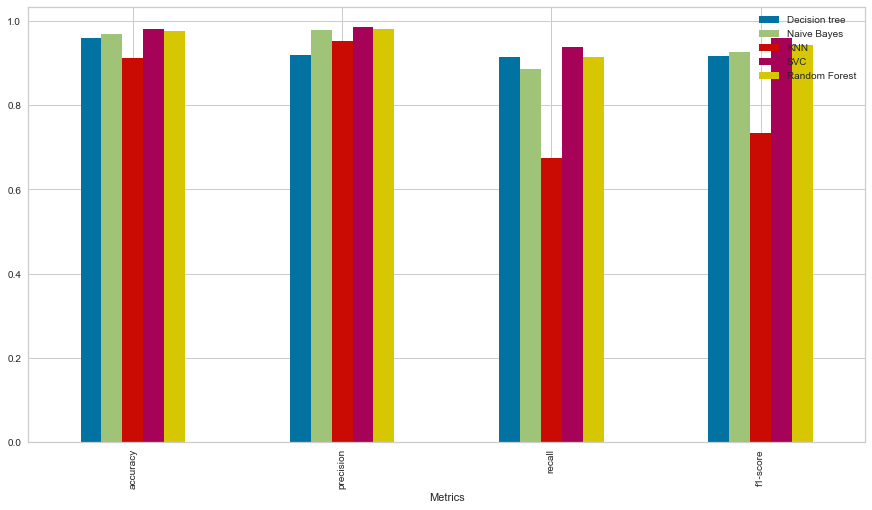

In [30]:
metrics_df.plot(kind='bar', figsize=(15,8))
plt.show()

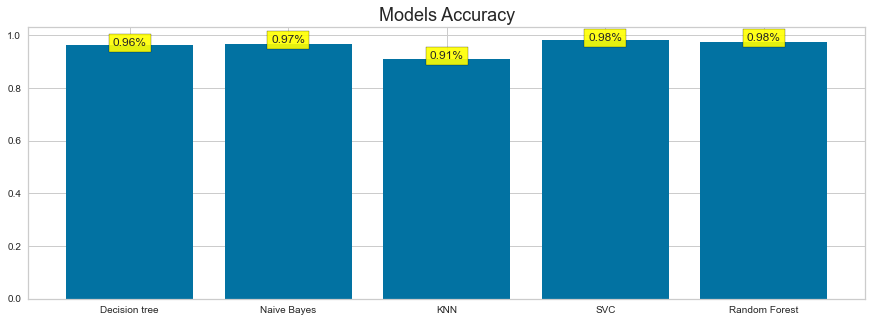

In [32]:
models_acc = metrics_df.iloc[0].tolist()
models_names = metrics_df.columns.tolist()
plt.figure(figsize=(15,5))
plt.bar(models_names,models_acc)
plt.title("Models Accuracy", fontsize=18)

def addLabels(names,acc):
    for i in range(len(names)):
        plt.text(i,round(acc[i],2),f"{round(acc[i],2)}%", ha = 'center', bbox=dict(facecolor='yellow', alpha=0.9))

addLabels(models_names,models_acc)
plt.show()

In [28]:
model_names = ["Decision tree", "Naive Bayes", "KNN Classifier", "SVC", "Random Forest Classifier"]
model_accuracies = [dtc_accuracy, nbc_accuracy, knnc_accuracy, svc_accuracy, rfc_accuracy]
index = np.argmax(model_accuracies)
print("Excellent accuracy Model:", model_names[index],
     "\nAccuracy:", round(model_accuracies[index], 2))

Excellent accuracy Model: Random Forest Classifier 
Accuracy: 0.98


# SVC Report

In [ ]:
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

tpr = tp/tp+fn
fpr = fp/fp+tn

print("Accuracy: ", accuracy)
print("False positve rate:", fpr)
print("True positive rate:", tpr)